This notebook will cover two models for the **SVR Model** on the **AMX Index**. The first model will be without Google SVI, but just a prediction based on historic prices. The second model will include Google SVI.

Results:
*   *Without* Google SVI: **54%** Hit Ratio
*   *With* Google SVI: **58%** Hit Ratio

Google SVI increases the number of **correct predictions** of the **direction** of the stock market by **4%**

For the error measures we have two different types, first the **Root Mean Square Error**, that measures average difference between predicted and actual values:
*   *Without* Google SVI: **28.40**
*   *With* Google SVI: **27.70**

This is a 0.70 point difference in favor of the model without Google SVI. This is a 2.4% difference.

Then, the **Mean Absolute Error**, which is the mean of the absolute values of the difference between the prediction and the actual value:
*   *Without* Google SVI: **24.24**
*   *With* Google SVI: **23.68**

Although the margins are not very large, in all three measures, the model with Google SVI outperforms the model without SVI. We can thus say this is not due to noise, but due to the fact that for this model, the introduction of Google SVI actually **improves the prediction accuracy!**

**Type I Data - Without SVI**

Importing Modules

In [2]:
# Importing Modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pmdarima as pm
import statsmodels.api as sm
from sklearn.svm import SVR

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


Here, we will first import the data that is uploaded from Google SVI. Then, we will do some renaming, and making sure that the "Date" column is the index.

After, we will download the data from Yahoo! Finance and make sure it is imported in the right format. Lastly, we will merge the Google SVI and Yahoo! data into one single dataframe, this time for the AMX Index. Below, a sample of the dataframe is shown.

In [3]:
# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx['Date'] = pd.to_datetime(dfamx['Date'])
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
dfaex = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
df = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMX SVI,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2015-01-02,0,636.469971,639.580017,632.200012,636.989990,636.989990,0
2015-01-09,7,636.590027,640.559998,631.409973,634.570007,634.570007,0
2015-01-16,9,639.500000,644.440002,637.109985,644.440002,644.440002,0
2015-01-23,0,661.630005,666.830017,660.919983,662.099976,662.099976,0
2015-01-30,0,670.080017,671.140015,668.239990,669.429993,669.429993,0
...,...,...,...,...,...,...,...
2019-11-29,72,879.280029,887.289978,879.280029,882.859985,882.859985,0
2019-12-06,73,881.659973,891.039978,878.950012,890.760010,890.760010,0
2019-12-13,78,904.130005,910.039978,897.140015,897.320007,897.320007,0


Next, we will select only the column "Open", because this is a type I model without Google SVI. Then, we will define the train-test split which is 90% for the training data, and 10% test data, this time divided through date. The training data is where the model learns on, and the test data is where the model tests its accuracy on. 

We will then scale the data as described in the paper.

In [ ]:
# Only Open Prices
columns = ['Open']
df = df[columns]

# Train Test
train_start_dt = '2015-01-01'
test_start_dt = '2019-06-28'
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Open']]
test = df.copy()[df.index >= test_start_dt][['Open']]

# Scaling Data
scaler = MinMaxScaler()
train['Open'] = scaler.fit_transform(train)
test['Open'] = scaler.transform(test)

# Converting to numpy arrays
train_data = train.values
test_data = test.values


First, we define timesteps in order to generate our x_train and y_train, and x_test and y_test. After we have done that, we can start to generate the model. The parameters are explained more elaborate in the paper itself. We have experimented with a lot of different combinations using for loops, optimal results were achieved using these parameters. Especially the gamma, and C are very important. More on this in the paper itself.

For now, the only relevant note is that we chose gamma 0.5 and C=10.

In [ ]:
# Defining Timesteps
timesteps=5
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

# Defining the model
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Next, we reshape the predictions, then we rescale the in order to align to our original scale and to be able to plot them against the same dates, on the same scale.

In [ ]:
# Reshape predictions & original data
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

# Rescale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

Next, this is the plotting part. Here, we plot the predictions in two graphs. The first graph contains a plot on the entire dataset, that is training **and** test set. The second graph shows only prediction and actual values of the test set, the set that the model has not seen before. This is also where we measure the accuracy and hit ratios.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


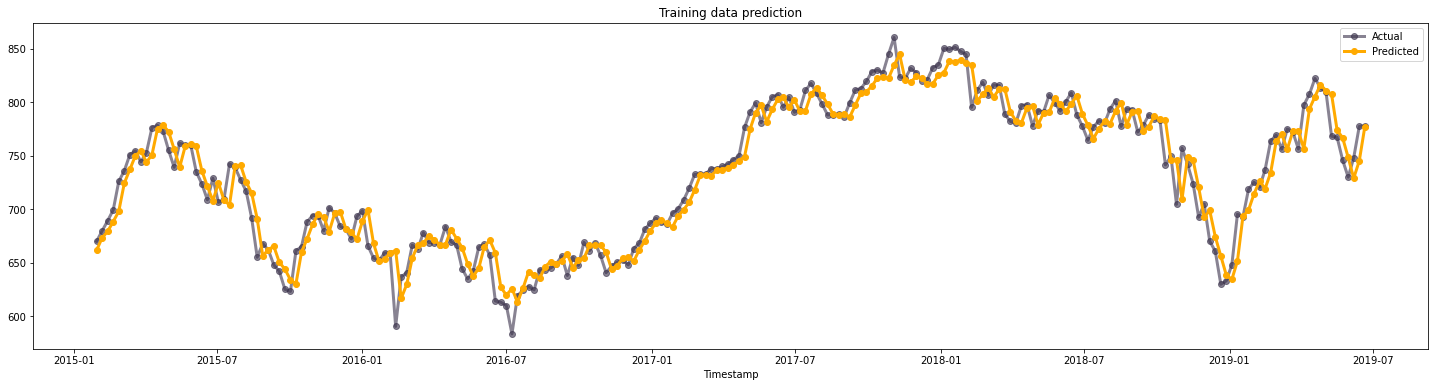

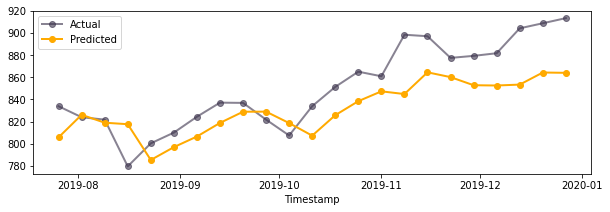

RMSE SVM: 28.399848151063313
MAE SVM: 24.24281855921456


In [2]:
# Prediction on Training Data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

# Prediction on Test Data
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = '#39304A', marker = 'o', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = '#FFAA00', marker = 'o', linewidth=2.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((y_test_pred - y_test) ** 2)))
print(f'RMSE SVM: {rmse}')
error = mae(y_test, y_test_pred)
print(f'MAE SVM: {error}')

From a visual perspective, the plots look pretty accurate. Of course, this is only a visual aspect, which is why we also have some error scores mentioned above and below, that are both explained in the paper. 

Below, we have calculated the hit ratio, which in this case is 0.54. This means that the model correctly predicts whether the data will increase or decrease **54%** of the time. The RMSE and MAE measures calculate how much "error" is in the values that the model predicts. 

In [4]:
df = pd.DataFrame(y_train_pred)
df['Actual Price'] = (y_train)
df['Predicted Price'] = (y_train_pred)

df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean() 

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.54


**Type II Data - With SVI**

Here, we will not explain every step for a second time, as the method is almost exactly identical, the only difference is that this time Google SVI is introduced to the model.

Results are better with Google SVI. The error measures Mean Absolute Error and Root Mean Square Error are lower when Google SVI is introduced. Moreover, the hit ratio increases from 54% to 58%, which is a four-percentage-point increase.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


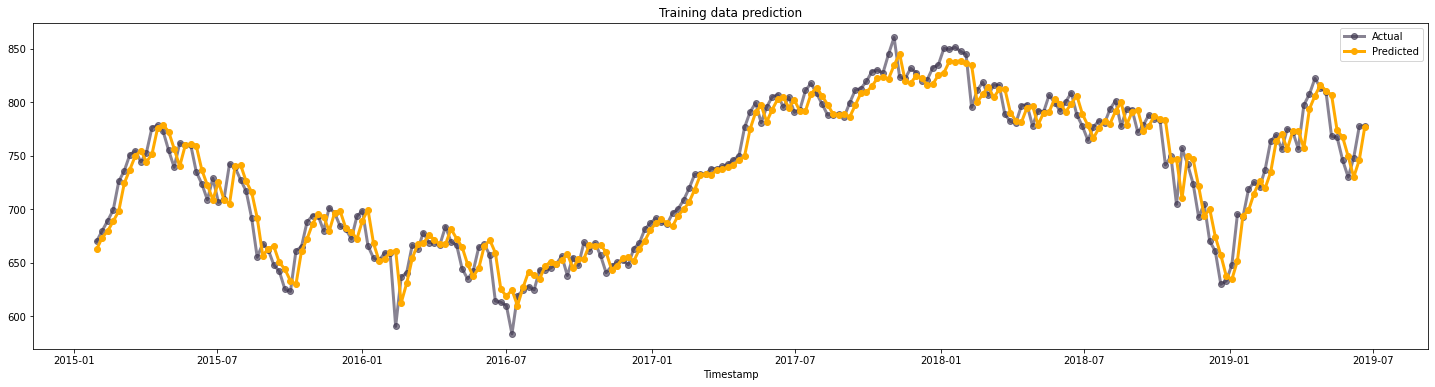

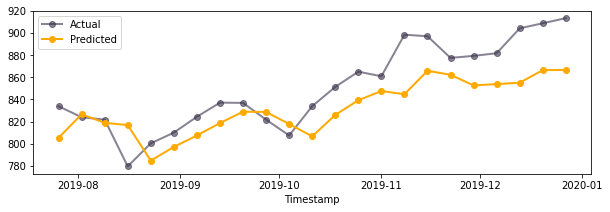

RMSE SVM: 27.695742338836414
MAE SVM: 23.67668068957612


In [6]:
# Importing SVI Data & Renaming
aex = pd.read_csv(r"/content/drive/MyDrive/AEX_5years_new.csv")
aex = aex.rename(columns={'AEX: (Wereldwijd)': 'AEX SVI'})
amx = pd.read_csv(r"/content/drive/MyDrive/AMX_5years_new.csv")
amx = amx.rename(columns={'AMX Index: (Wereldwijd)': 'AMX SVI'})
dfaex = pd.DataFrame(aex)
dfamx = pd.DataFrame(amx)

# Renaming Columns 
dfaex = dfaex.rename(columns={'Week': 'Date'})
dfaex['Date'] = pd.to_datetime(dfaex['Date'])
dfaex = dfaex.set_index('Date')

dfamx = dfamx.rename(columns={'Week': 'Date'})
dfamx['Date'] = pd.to_datetime(dfamx['Date'])
dfamx = dfamx.set_index('Date')

# Pulling Yahoo Finance Data
# Defining tickers & dates
ticker_aex = ['^AEX']
ticker_amx = ['^AMX']
start_date = '2015-01-01'
end_date = '2019-12-28'

# Downloading & transforming data to weekly data machting SVI
yfaex = yf.download(ticker_aex, start_date, end_date)
yfaex = yfaex.asfreq('W-FRI', method='pad') 
yfaex = pd.DataFrame(yfaex)

yfamx = yf.download(ticker_amx, start_date, end_date)
yfamx = yfamx.asfreq('W-FRI', method='pad') 
yfamx = pd.DataFrame(yfamx)

# Merging Datasets
dfaex = pd.merge(dfaex, yfaex, left_index=True, right_index=True, how='outer')
df = pd.merge(dfamx, yfamx, left_index=True, right_index=True, how='outer')
df

# Only Open Prices
columns = ['Open', 'AMX SVI']
df = df[columns]

# Train Test
train_start_dt = '2015-01-01'
test_start_dt = '2019-06-28'
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Open', 'AMX SVI']]
test = df.copy()[df.index >= test_start_dt][['Open', 'AMX SVI']]

# Scaling Data
scaler = MinMaxScaler()
train['Open'] = scaler.fit_transform(train)
test['Open'] = scaler.transform(test)

scalerx = MinMaxScaler()
train['AMX SVI'] = scalerx.fit_transform(train)
test['AMX SVI'] = scalerx.transform(test)

# Converting to numpy arrays
train_data = train.values
test_data = test.values

# Defining Timesteps
timesteps=5
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

# Defining the model
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

# Reshape predictions & original data
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

# Rescale
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

# Prediction on Training Data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = '#39304A', marker = 'o', linewidth=3.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = '#FFAA00', marker = 'o', linewidth=3.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

# Prediction on Test Data
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = '#39304A', marker = 'o', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = '#FFAA00', marker = 'o', linewidth=2.0)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

# Evaluation
from sklearn.metrics import mean_absolute_error as mae
rmse = np.sqrt(np.mean(((y_test_pred - y_test) ** 2)))
print(f'RMSE SVM: {rmse}')
error = mae(y_test, y_test_pred)
print(f'MAE SVM: {error}')

In [8]:
df = pd.DataFrame(y_train_pred)
df['Actual Price'] = (y_train)
df['Predicted Price'] = (y_train_pred)

df['Actual_Price'] = df['Actual Price'].diff()
df['Actual_Price'] = df['Actual_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Create a new column that indicates whether the predicted value increased or decreased
df['Predicted_Price'] = df['Predicted Price'].diff()
df['Predicted_Price'] = df['Predicted_Price'].apply(lambda x: 'increase' if x > 0 else 'decrease')

# Calculate the hit ratio
hit_ratio = (df['Actual_Price'] == df['Predicted_Price']).mean()

print(f'Hit ratio: {hit_ratio:.2f}')

Hit ratio: 0.58
